[View in Colaboratory](https://colab.research.google.com/github/JacksonIsaac/colab_notebooks/blob/master/kaggle_tgs_salt_identification.ipynb)

### Kaggle notebook
For *TGS Salt identification* competition:

https://www.kaggle.com/c/tgs-salt-identification-challenge

# Setup kaggle and download dataset

In [2]:
!pip install kaggle

In [2]:
## Load Kaggle config JSON
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

Download 100%.


In [3]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 62.8MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 70.5MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 92.9MB/s]
 94% 154M/163M [00:00<00:00, 150MB/s]
100% 163M/163M [00:00<00:00, 186MB/s]
 92% 35.0M/37.9M [00:00<00:00, 42.2MB/s]
100% 37.9M/37.9M [00:00<00:00, 78.5MB/s]


In [4]:
!ls

adc.json    sample_data		   test.zip   train.zip
depths.csv  sample_submission.csv  train.csv


In [0]:
!unzip -q train.zip
!unzip -q test.zip

# Install Dependencies

In [6]:
!pip install -q imageio
!pip install -q torch

tcmalloc: large alloc 1073750016 bytes == 0x590d2000 @  0x7fa2b66e71c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
!pip install -q ipywidgets

In [0]:
import os
import numpy as np

import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data

# Create class for input dataset

In [0]:
class TGSSaltDataSet(data.Dataset):
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        file_id = self.file_list[index]
        
        # Image folder
        image_folder = os.path.join(self.root_path, 'images')
        image_path = os.path.join(image_folder, file_id+ '.png')
        
        # Label folder
        mask_folder = os.path.join(self.root_path, 'masks')
        mask_path = os.path.join(mask_folder, file_id+ '.png')
        
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        
        return image, mask

# Load dataset csv

In [0]:
train_mask = pd.read_csv('train.csv')
depth = pd.read_csv('depths.csv')

train_path = './'

file_list = list(train_mask['id'].values)

dataset = TGSSaltDataSet(train_path, file_list)

# Visualize dataset

In [0]:
def plot2x2array(image, mask):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image)
    axs[1].imshow(mask)
    
    axs[0].grid()
    axs[1].grid()
    
    axs[0].set_title('Image')
    axs[1].set_title('Mask')

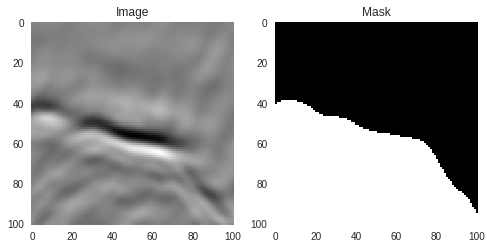

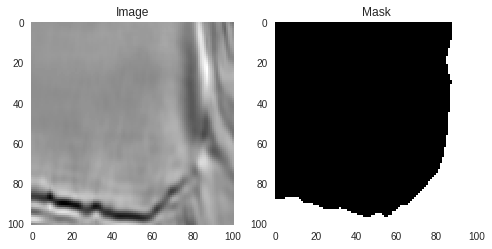

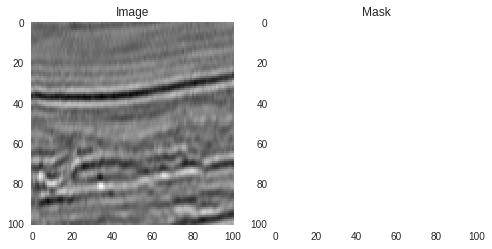

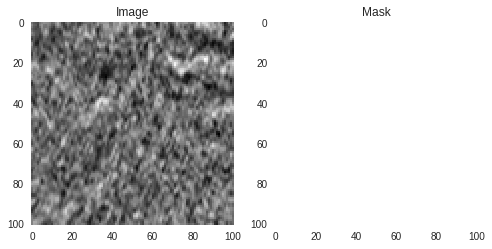

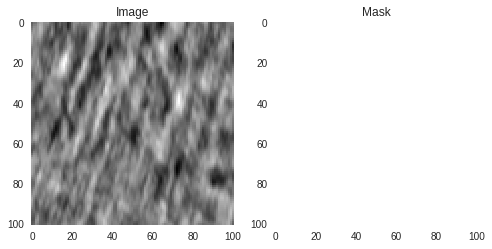

In [23]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2array(image, mask)

Text(0.5,1,'Depth distribution')

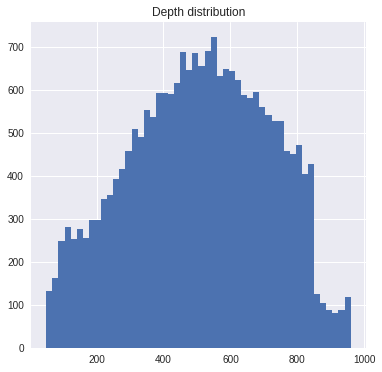

In [24]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

# Convert RLE Mask to matrix

In [0]:
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    try:
        rle_numbers = [int(numstr) for numstr in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        img = np.zeros(rows * cols, dtype=np.uint8)
        
        for idx, length in rle_pairs:
            idx -= 1
            img[idx:idx+length] = 255
            
        img = img.reshape(cols, rows)
        
        img = img.T
        
    except:
        img = np.zeros((cols, rows))
        
    return img

In [0]:
def salt_proportion(img_array):
    try:
        unique, counts = np.unique(img_array, return_counts=True)
        return counts[1]/10201.
    except:
        return 0.0

# Create training mask

In [0]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rle_to_mask(x, 101, 101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

# Let's merge the mask and depths

In [13]:
merged = train_mask.merge(depth, how='left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt vs depth')

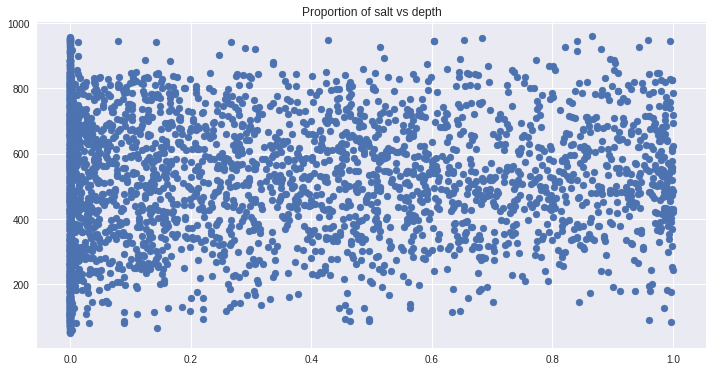

In [29]:
plt.figure(figsize=(12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt vs depth')

In [30]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])

Correlation:  0.10361580365557428


# Setup Keras and Train

In [4]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [74]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 128, 128, 8)  584         conv2d_77[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
conv2d_79 

In [16]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"masks"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + 'images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + 'masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 4000/4000 [00:23<00:00, 160.67it/s]

Done!


In [35]:
!ls ./masks

000e218f21.png	35499d9dd6.png	6957579961.png	99f52af0ea.png	cc876896b5.png
003c477d7c.png	356fa48ac4.png	697af33de9.png	9a1fbef3e3.png	cc97e87765.png
00441f1cf2.png	3577258d6b.png	697f80cece.png	9a3abd0ba6.png	ccc41663c6.png
0050766ae2.png	358b9acfb5.png	697fee88c5.png	9a478d8cf2.png	ccd6841e90.png
005b452274.png	359128303c.png	6994342067.png	9a48617407.png	ccdd1c542f.png
0061281eea.png	3598c246d7.png	699608ddb7.png	9a4864ff06.png	cced2adf43.png
008a50a2ec.png	35b34a9da1.png	69bb149e2d.png	9a4b15919d.png	ccfb270edb.png
00950d1627.png	35ba6f2faf.png	69cddf572c.png	9a4db0d7aa.png	cd1b2e49f4.png
00a3af90ab.png	35bbf1302b.png	69ee613976.png	9a4f625408.png	cd2046479c.png
00cda0328c.png	35f3cb48d6.png	6a0f5a8b42.png	9a672bfb51.png	cd249859fa.png
0108518d1e.png	35fd991255.png	6a105e7555.png	9a6c280d8d.png	cd292b7c8d.png
010ee525b6.png	361d5e6834.png	6a1783be17.png	9a6cf411ff.png	cd5c9532e4.png
0115703825.png	362cec7849.png	6a1fd3c67e.png	9a71e8563b.png	cd5cd074f1.png
01323211a0.png	3634f29aac

In [39]:
!ls ./images

0005bb9630.png	3474172578.png	6723526c1a.png	990468763b.png	cc2c7789b8.png
000a68e46c.png	3474bba21d.png	6724070ec9.png	990a672905.png	cc2da77c17.png
000c8dfb2a.png	347686c1b9.png	672b6c08a1.png	990d808b85.png	cc2fc654f5.png
000d0a5f6c.png	3476cc2c7c.png	672bb9b070.png	9911b2b904.png	cc30dc52ee.png
000e218f21.png	347d3a7801.png	6730d663de.png	9913721ee5.png	cc31e0720c.png
001ef8fc87.png	3480629331.png	67320e41a5.png	9917602913.png	cc32da1b7d.png
002124aa19.png	348232af8d.png	67358e3002.png	991d9bf376.png	cc383f3d4d.png
002af5d1e8.png	34831dcd0c.png	6736047f57.png	991ec143b1.png	cc3cd53279.png
00323f1910.png	3484c36b51.png	67377e2624.png	991f1104ec.png	cc3fa7233a.png
00329dc15c.png	34882b481e.png	6738994f95.png	991f239daf.png	cc4153a0ba.png
0035c56490.png	348b3df20a.png	6738d474a3.png	9922cd597b.png	cc4344175e.png
003c477d7c.png	348f475161.png	673d620dca.png	9923de1c7f.png	cc435c1f0b.png
0041cb8c49.png	349516c6c0.png	673ec36187.png	992572448c.png	cc45eeeafb.png
0043a01a19.png	3496c1d5b3

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [0]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-2.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [77]:
results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 20s 6ms/step - loss: 0.5518 - val_loss: 0.4322

Epoch 00001: val_loss improved from inf to 0.43223, saving model to model-tgs-salt-2.h5
Epoch 2/50
3400/3400 [==============================] - 17s 5ms/step - loss: 0.4242 - val_loss: 0.3713

Epoch 00002: val_loss improved from 0.43223 to 0.37132, saving model to model-tgs-salt-2.h5
Epoch 3/50
3400/3400 [==============================] - 17s 5ms/step - loss: 0.3469 - val_loss: 0.4525

Epoch 00003: val_loss did not improve from 0.37132
Epoch 4/50
3400/3400 [==============================] - 17s 5ms/step - loss: 0.2967 - val_loss: 0.2642

Epoch 00004: val_loss improved from 0.37132 to 0.26422, saving model to model-tgs-salt-2.h5
Epoch 5/50
3400/3400 [==============================] - 17s 5ms/step - loss: 0.2647 - val_loss: 0.2500

Epoch 00005: val_loss improved from 0.26422 to 0.24997, saving model to model-tgs-salt-2.h5
Epoch 6/50
3400/34

In [19]:
!ls

adc.json    images  model-tgs-salt-1.h5  sample_submission.csv	train.csv
depths.csv  masks   sample_data		 test.zip		train.zip


In [25]:
!unzip -q test.zip -d test

replace test/images/8cf16aa0f5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Predict
Ref: https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics

In [85]:
path_test='./test/'

test_ids = next(os.walk(path_test+"images"))[2]

X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
X_test_feat = np.zeros((len(test_ids), n_features), dtype=np.float32)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    
    img = load_img(path + 'images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    
    # Save images
    X_test[n, ..., 0] = x_img.squeeze() / 255
    X_test[n, ..., 1] = x_csum.squeeze()
    
    #img = load_img(path + '/images/' + id_)
    #x = img_to_array(img)[:,:,1]
    sizes_test.append([x_img.shape[0], x_img.shape[1]])
    #x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    #X_test[n] = x

print('Done!')



#test_mask = pd.read_csv('test.csv')
#file_list = list(train_mask['id'].values)
#dataset = TGSSaltDataSet(train_path, file_list)

Getting and resizing test images ... 


100%|██████████| 18000/18000 [01:05<00:00, 275.97it/s]

Done!


In [32]:
X_train.shape

(3400, 128, 128, 2)

In [33]:
X_test.shape

(18000, 128, 128, 2)

In [56]:
!ls -al

total 210516
drwxr-xr-x 1 root root      4096 Sep 14 21:18 .
drwxr-xr-x 1 root root      4096 Sep 14 16:19 ..
-rw-r--r-- 1 root root      2556 Sep 14 17:05 adc.json
drwxr-xr-x 1 root root      4096 Sep 14 17:05 .config
-rw-r--r-- 1 root root    329525 Sep 14 17:06 depths.csv
drwxr-xr-x 2 root root    790528 Sep 14 19:16 images
drwxr-xr-x 2 root root      4096 Sep 14 17:05 .kaggle
drwxr-xr-x 2 root root    135168 Jul 16 19:26 masks
-rw-r--r-- 1 root root   2030528 Sep 14 21:13 model-tgs-salt-1.h5
drwxr-xr-x 2 root root      4096 Sep 13 17:28 sample_data
-rw-r--r-- 1 root root    270012 Sep 14 17:06 sample_submission.csv
drwxr-xr-x 3 root root      4096 Sep 14 21:18 test
-rw-r--r-- 1 root root 171262199 Sep 14 17:06 test.zip
-rw-r--r-- 1 root root    943702 Sep 14 17:06 train.csv
-rw-r--r-- 1 root root  39757560 Sep 14 17:06 train.zip


In [79]:
preds_test = model.predict([X_test, X_test_feat], verbose=1)

18000/18000 [==============================] - 23s 1ms/step


In [0]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
from tqdm import tnrange

In [86]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs


In [0]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
from tqdm import tqdm_notebook

In [95]:
#pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [0]:
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [101]:
threshold_best = 0.77
img_size_ori = 101
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [103]:
sub.head()

,rle_mask
id,
353e010b7b,5367 3 5495 1 6782 1 7806 2 7933 4 8059 2 8062...
5439dbbddf,81 19 210 20 339 18 467 17 485 1 579 5 594 21 ...
71bab9f311,115 13 242 15 371 14 500 13 627 14 756 13 884 ...
52551f7a80,5500 3 5628 3 5755 4 5881 7 6008 9 6135 10 626...
512d8d9997,7420 5 7545 8 7673 8 7801 8 7929 8 8057 8 8185...


In [89]:
!ls

adc.json    masks		 sample_data		test	   train.zip
depths.csv  model-tgs-salt-1.h5  sample_submission.csv	test.zip
images	    model-tgs-salt-2.h5  submission.csv		train.csv


In [104]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "Re-Submission with U-Net"

Successfully submitted to TGS Salt Identification Challenge

# Predict
Ref: https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks

In [0]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-new-1.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [52]:
#results = model.fit({'img': [X_train, X_train], 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
#                    validation_data=({'img': [X_valid, X_valid], 'feat': X_feat_valid}, y_valid))

epochs = 50
batch_size = 16

history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

ValueError: ignored

In [0]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [0]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [45]:
img_size_target = 101

x_test = np.array([(np.array(load_img("./test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)


100%|██████████| 18000/18000 [00:15<00:00, 1187.66it/s]

In [0]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [47]:
preds_test = predict_result(model,x_test,img_size_target)

ValueError: ignored

# Save output to drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [112]:
!ls /content/gdrive/My\ Drive/kaggle_competitions

catsvsdogs  colab_test.py  digit_recognizer  kaggle.json  tgs_salt


In [0]:
!cp model-tgs-salt-1.h5 /content/gdrive/My\ Drive/kaggle_competitions/tgs_salt/
!cp model-tgs-salt-2.h5 /content/gdrive/My\ Drive/kaggle_competitions/tgs_salt/
!cp submission.csv /content/gdrive/My\ Drive/kaggle_competitions/tgs_salt/submission.csv